# **PORTFOLIO OPTIMIZATION**

# **1.0 INTRODUCTION**
The aim of this project is to utilise ***reinforcement learning*** to train a machine to learn how to rebalance a portfolio of stocks given what happened prior in the market. For this project, our portfilio will initially focus on the ***Dow Jones Index*** of **30 constituents**.

## **1.1 Import Dependencies**

In [ ]:
# install yfinance library
!pip install yfinance

## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

# install ta library for technical analysis
!pip install ta

# install the pyfolio library
!pip install pyfolio

# install optuna
!pip install optuna

     |████████████████████████████████| 63 kB 790 kB/s 
     |████████████████████████████████| 6.4 MB 12.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-yplqhiv0
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-yplqhiv0
  Cloning 

  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=0182327aed761747a3529ce537ad3ea64593dd4f1b15d8e77d16b97aa0f424ec
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 210 kB 51.4 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 
     |████████████████████████████████| 113 kB 47.3 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 150 kB 51.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5297c17e0b4aff3741d18b4b9de0f2249eda192386ecfb4b5bfd3348dc3c4007
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [122]:
import yfinance as yf
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import seaborn as sns
from functools import reduce
import numpy as np
%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

In [ ]:
import os
from finrl import config
from finrl import config_tickers

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

## **1.2 Data Collection & Cleaning**
We'll select the stocks from the DOW JONES for our analysis.

In [ ]:
DOW_30_TICKERS = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC", 
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
    "DOW"
]

We'll make dictionaries for each ticker and store financial data within them. 
<br><br>
We'll focus on ticker name, the yahoo finance object, info and historical prices over the past ***10 years***.
<br><br>
For each ticker, the financial information will be represented by a dataframe.


In [ ]:
DOW_tickers_data = []
for ticker in DOW_30_TICKERS:
    ticker_dict = {
                   'ticker': ticker, 
                   'info': yf.Ticker(ticker).info,
                   'daily_prices':yf.download(ticker, period = '10y', interval = '1d')
                   }
    DOW_tickers_data.append(ticker_dict)

Here is an example of one of historical data for one of our constituents.

In [ ]:
DOW_tickers_data[0]['daily_prices'].head()

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2012-03-28  58.380001  59.259998  58.380001  59.060001  51.164398  7925900
2012-03-29  58.279999  58.439999  57.240002  57.889999  50.150810  7397600
2012-03-30  58.180000  58.310001  57.540001  57.860001  50.124840  5779700
2012-04-02  57.900002  58.330002  57.470001  58.009998  50.254772  6674200
2012-04-03  57.889999  58.500000  57.750000  58.389999  50.758968  5782800

We'll now make a few changes to our dataframes.

In [ ]:
# assign a column order for our dataframes
column_order = ['date', 'open', 'high', 'low', 'close', 'adjcp', 'volume',	'tic', 'day']

for ticker in DOW_tickers_data:
    # make the index a datetime object
    ticker['daily_prices'] = ticker['daily_prices'].reset_index()
    ticker['daily_prices'] = ticker['daily_prices'].rename({'Date': 'date'}, axis = 1)
    ticker['daily_prices']['date'] = pd.to_datetime(ticker['daily_prices']['date'])
    # add a column for 'day of the week'
    ticker['daily_prices']['day'] = ticker['daily_prices']['date'].dt.dayofweek
    # add the ticker name to the dataframe
    ticker['daily_prices']['tic'] = ticker['ticker']
    # rename the adjusted closing price column
    ticker['daily_prices'] = ticker['daily_prices'].rename({'Adj Close': 'adjcp'}, axis = 1)
    # set a column order for our dataframes
    ticker['daily_prices'].columns = ticker['daily_prices'].columns.str.lower()
    ticker['daily_prices'] = ticker['daily_prices'][column_order]
    # convert date column back to str
    ticker['daily_prices']['date'] = ticker['daily_prices']['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
DOW_tickers_data[0]['daily_prices']

date        open        high         low       close       adjcp  \
0     2012-03-28   58.380001   59.259998   58.380001   59.060001   51.164398   
1     2012-03-29   58.279999   58.439999   57.240002   57.889999   50.150810   
2     2012-03-30   58.180000   58.310001   57.540001   57.860001   50.124840   
3     2012-04-02   57.900002   58.330002   57.470001   58.009998   50.254772   
4     2012-04-03   57.889999   58.500000   57.750000   58.389999   50.758968   
...          ...         ...         ...         ...         ...         ...   
2512  2022-03-22  190.500000  194.350006  190.059998  191.330002  191.330002   
2513  2022-03-23  188.830002  189.619995  185.179993  186.020004  186.020004   
2514  2022-03-24  186.610001  189.369995  185.699997  188.889999  188.889999   
2515  2022-03-25  190.410004  191.259995  189.000000  190.279999  190.279999   
2516  2022-03-28  189.949997  189.509995  187.220001  187.869995  187.869995   

       volume  tic  day  
0     7925900  AXP    2  
1     7397600  AXP    3  
2     5779700  AXP    4  
3     6674200  AXP    0  
4     5782800  AXP    1  
...       ...  ...  ...  
2512  3007000  AXP    1  
2513  3664600  AXP    2  
2514  2424400  AXP    3  
2515  1871900  AXP    4  
2516   390328  AXP    0  

[2517 rows x 9 columns]

We'll now compile a list of the historical prices dataframes so we can create a ***panel dataset***.

In [ ]:
DOW_tickers_prices = [ticker['daily_prices'] for ticker in DOW_tickers_data]

# And then compile them into a single dataframe
DOW_tickers_panel_dataset = pd.concat(DOW_tickers_prices)
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset[column_order]
DOW_tickers_panel_dataset.head()

date       open       high        low      close      adjcp  \
0  2012-03-28  58.380001  59.259998  58.380001  59.060001  51.164398   
1  2012-03-29  58.279999  58.439999  57.240002  57.889999  50.150810   
2  2012-03-30  58.180000  58.310001  57.540001  57.860001  50.124840   
3  2012-04-02  57.900002  58.330002  57.470001  58.009998  50.254772   
4  2012-04-03  57.889999  58.500000  57.750000  58.389999  50.758968   

      volume  tic  day  
0  7925900.0  AXP    2  
1  7397600.0  AXP    3  
2  5779700.0  AXP    4  
3  6674200.0  AXP    0  
4  5782800.0  AXP    1

In [ ]:
DOW_tickers_panel_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73730 entries, 0 to 761
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    73730 non-null  object 
 1   open    73729 non-null  float64
 2   high    73729 non-null  float64
 3   low     73729 non-null  float64
 4   close   73729 non-null  float64
 5   adjcp   73729 non-null  float64
 6   volume  73729 non-null  float64
 7   tic     73730 non-null  object 
 8   day     73730 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.6+ MB


We'll have a look to see if there are any na values.

In [ ]:
DOW_tickers_panel_dataset[pd.isna(DOW_tickers_panel_dataset['open'])]

date  open  high  low  close  adjcp  volume  tic  day
957  2016-01-18   NaN   NaN  NaN    NaN    NaN     NaN  CAT    0

There does seem to be a single record that consists of na values for this particular stock. <br>
<br>
We'll deal with it using ***backfill***.

In [ ]:
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset.backfill()
DOW_tickers_panel_dataset.shape

(73730, 9)

What we need to also check is how many tickers have a full set of values we have for unique date.

In [ ]:
DOW_tickers_panel_dataset.groupby('date').count().sort_values(by = 'tic')

open  high  low  close  adjcp  volume  tic  day
date                                                       
2016-01-18     1     1    1      1      1       1    1    1
2022-03-28     3     3    3      3      3       3    3    3
2016-11-28    29    29   29     29     29      29   29   29
2016-11-25    29    29   29     29     29      29   29   29
2016-11-23    29    29   29     29     29      29   29   29
...          ...   ...  ...    ...    ...     ...  ...  ...
2020-03-25    30    30   30     30     30      30   30   30
2020-03-26    30    30   30     30     30      30   30   30
2020-03-27    30    30   30     30     30      30   30   30
2020-03-16    30    30   30     30     30      30   30   30
2019-11-07    30    30   30     30     30      30   30   30

[2518 rows x 8 columns]

Oddly, we see there are 3 tickers that have values on the ***28th of March 2022*** as well as 1 ticker on the ***18th of Jan 2016***. <br><br>
We'll need to drop these records as our algorithm won't work with this dataset.

In [ ]:
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['date'] != '2016-01-18']
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['date'] != '2022-03-28']
DOW_tickers_panel_dataset

date       open       high        low      close      adjcp  \
0    2012-03-28  58.380001  59.259998  58.380001  59.060001  51.164398   
1    2012-03-29  58.279999  58.439999  57.240002  57.889999  50.150810   
2    2012-03-30  58.180000  58.310001  57.540001  57.860001  50.124840   
3    2012-04-02  57.900002  58.330002  57.470001  58.009998  50.254772   
4    2012-04-03  57.889999  58.500000  57.750000  58.389999  50.758968   
..          ...        ...        ...        ...        ...        ...   
757  2022-03-21  63.119999  63.720001  62.529999  63.340000  63.340000   
758  2022-03-22  64.000000  64.529999  63.240002  63.549999  63.549999   
759  2022-03-23  63.400002  63.840000  63.020000  63.299999  63.299999   
760  2022-03-24  63.759998  64.199997  63.410000  64.089996  64.089996   
761  2022-03-25  64.089996  64.730003  63.840000  64.699997  64.699997   

        volume  tic  day  
0    7925900.0  AXP    2  
1    7397600.0  AXP    3  
2    5779700.0  AXP    4  
3    6674200.0  AXP    0  
4    5782800.0  AXP    1  
..         ...  ...  ...  
757  4836500.0  DOW    0  
758  5136700.0  DOW    1  
759  2936100.0  DOW    2  
760  3611400.0  DOW    3  
761  3962900.0  DOW    4  

[73726 rows x 9 columns]

So our panel dataset has over 73,000 rows with 9 columns and one of those columns includes the ticker name.
<br><br>
We'll now export this dataframe into a csv.

In [ ]:
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset.reset_index().drop('index', axis = 1)
DOW_tickers_panel_dataset.to_csv('data/DOW_tickers_panel_dataset.csv', index=True)

In [4]:
DOW_tickers_panel_dataset = pd.read_csv('data/DOW_tickers_panel_dataset.csv').drop('Unnamed: 0', axis = 1)

## **1.3 EDA**
With our panel dataset created, we can now perform simple EDA and data visualisations.

We can visualise the median changes in price across the years.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f0525be68c0> (for post_execute):


KeyboardInterrupt: ignored

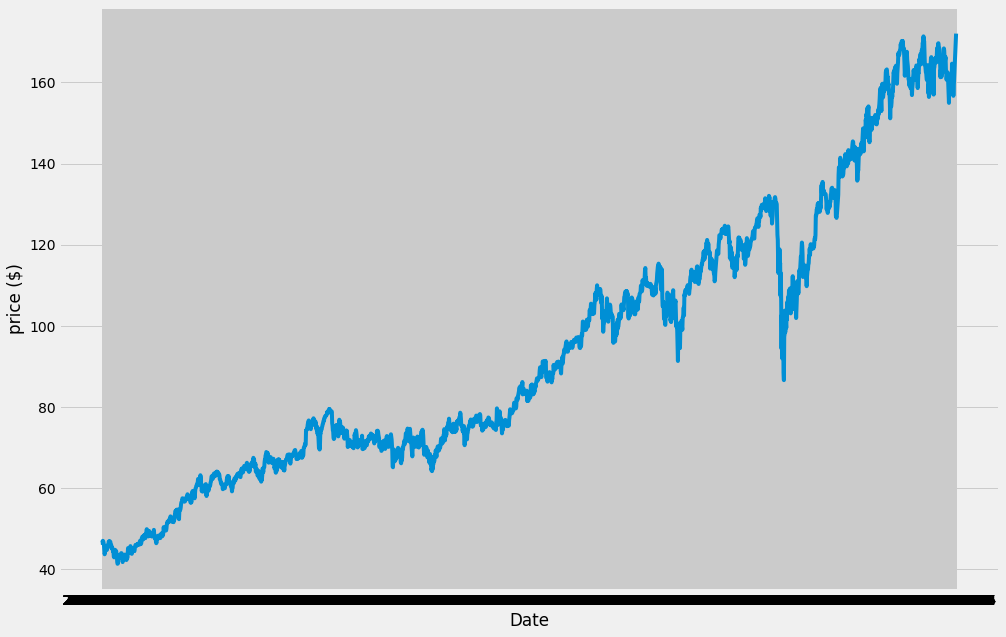

In [ ]:
median_panel_dataset = DOW_tickers_panel_dataset.groupby('date').median().reset_index()

fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.lineplot(data = median_panel_dataset, 
                    x = 'date',
                    y = 'adjcp')
ax.set_ylabel('price ($)')
ax.set_xlabel('Date');

A more important metric would be viewing average ***ROI***.
<br><br>
We'll firstly calculate it per ticker.

In [ ]:
ROI_df_list = []

for ticker in DOW_30_TICKERS:
    df = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['tic'] == ticker]
    df['ROI'] = df['adjcp'].pct_change()
    df = df.dropna()
    ROI_df_list.append(df)

We'll then turn list of dataframes into a single panel set and calculate the median ROI.

In [ ]:
ROI_panel = pd.concat(ROI_df_list)
median_ROI_panel = ROI_panel.groupby('date').median().reset_index()

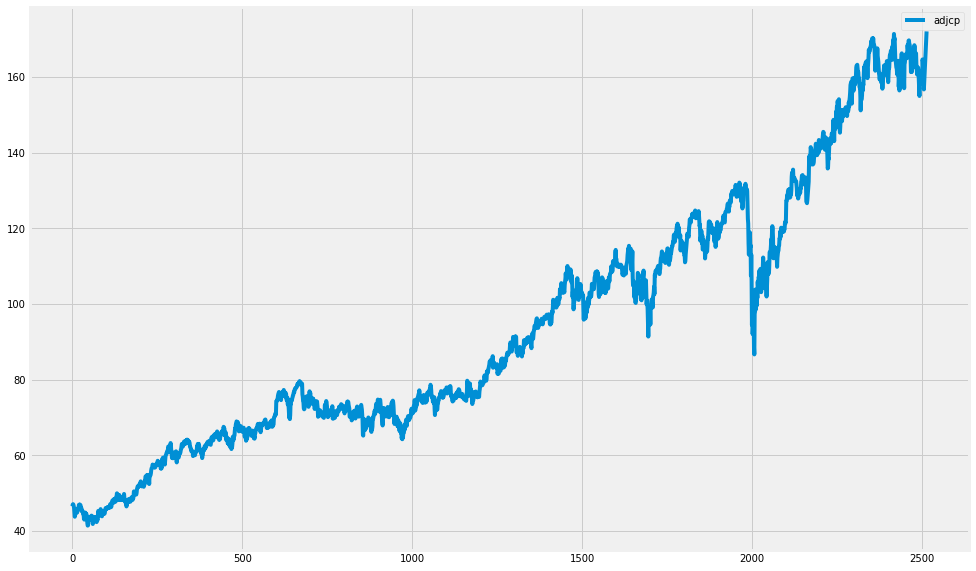

In [ ]:
median_ROI_panel[['date', 'adjcp']].plot(figsize = (15, 10));

The median ROI is relatively stable throughout the 10 years apart from around early 2020 due to covid and lockdown rules.
<br><br>
What we can do now is look at the top performing tickers over a range of time periods:
- ***1 month***
- ***6 month***
- ***1 year***

In [ ]:
ROI_list = []

for ticker in DOW_30_TICKERS:
    df = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['tic'] == ticker]
    # we'll take the prior values for each time period
    month_1_prior = df.iloc[-22]['adjcp']
    month_6_prior = df.iloc[-(22 * 6)]['adjcp']
    year_1_prior = df.iloc[-(22 * 12)]['adjcp']
    current_value = df.iloc[-1]['adjcp']
    # now we'll calculate the ROIs
    month_1_ROI = ((100 / month_1_prior) * current_value) - 100
    month_6_ROI = ((100 / month_6_prior) * current_value) - 100
    year_1_ROI = ((100 / year_1_prior) * current_value) - 100

    summary_dict = {'ticker': ticker,
                    'month_1_ROI': month_1_ROI, 
                    'month_6_ROI': month_6_ROI,
                    'year_1_ROI': year_1_ROI}

    ROI_list.append(summary_dict)

In [ ]:
ROI_df = pd.DataFrame(ROI_list)
ROI_df.head()

ticker  month_1_ROI  month_6_ROI  year_1_ROI
0    AXP     1.024684    16.661660   30.157042
1   AMGN     8.902261    10.702629    6.612269
2   AAPL     7.361433    19.949286   44.111556
3     BA    -4.777501   -11.440759  -25.019842
4    CAT    20.937786    12.982769    3.713072

**1 month ROI**

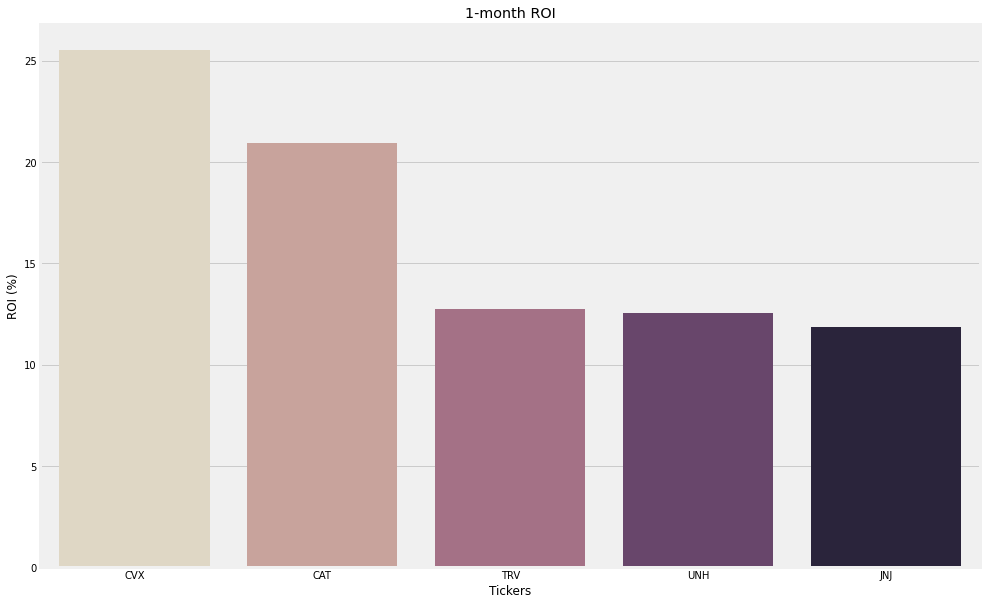

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
month_1_ROI_df = ROI_df[['ticker', 'month_1_ROI']].sort_values('month_1_ROI', ascending = False).head()
ax = sns.barplot(data = month_1_ROI_df, 
                x = 'ticker', 
                y = 'month_1_ROI',
                palette = sns.color_palette('ch:s=-.2,r=.6', n_colors=5))
ax.set_title('1-month ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

**6 month ROI**

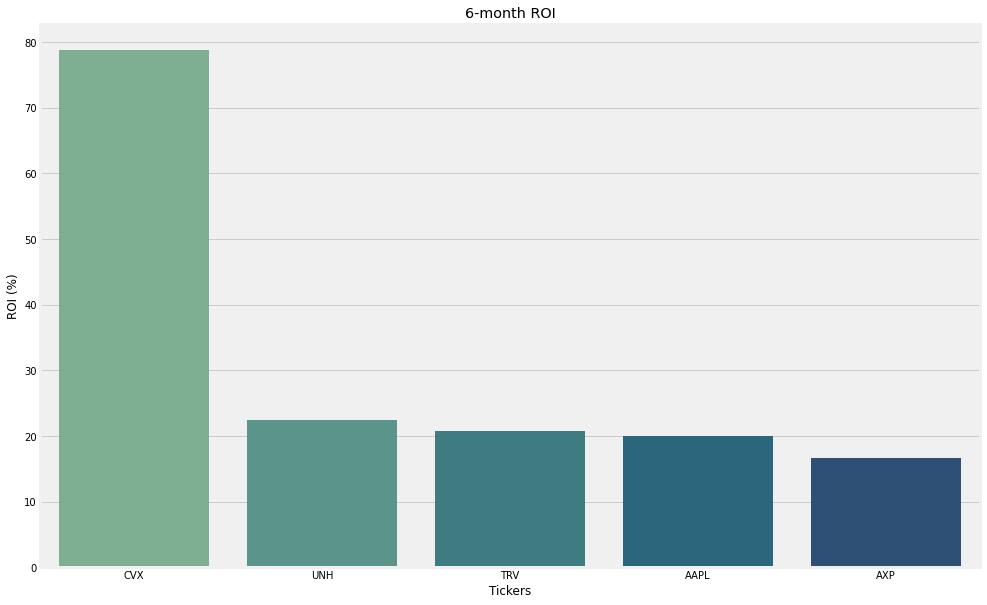

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
month_6_ROI_df = ROI_df[['ticker', 'month_6_ROI']].sort_values('month_6_ROI', ascending = False).head()
ax = sns.barplot(data = month_6_ROI_df, 
                x = 'ticker', 
                y = 'month_6_ROI',
                palette = sns.color_palette('crest', n_colors=5))
ax.set_title('6-month ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

**1 year ROI**

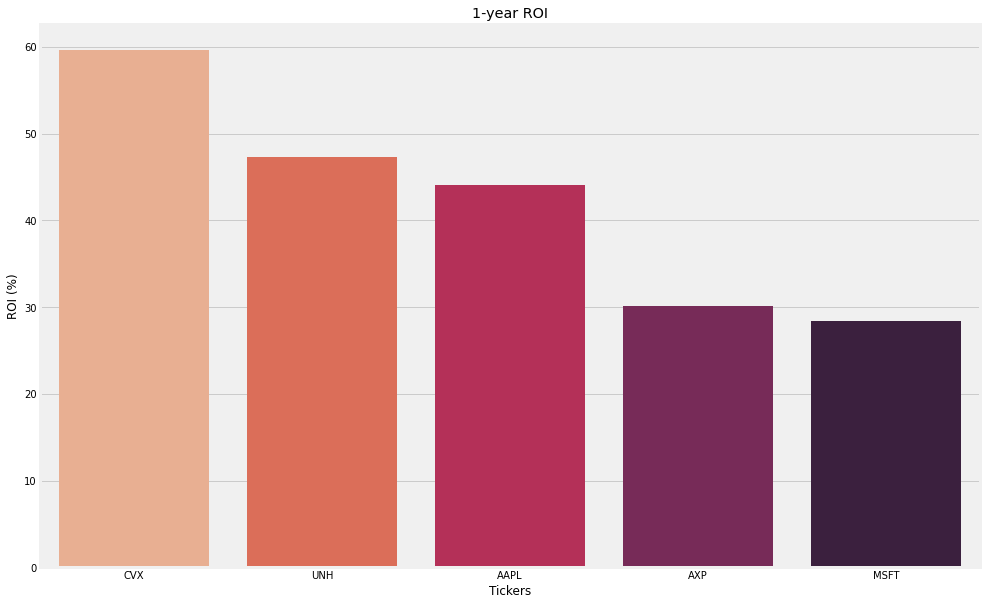

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
year_1_ROI_df = ROI_df[['ticker', 'year_1_ROI']].sort_values('year_1_ROI', ascending = False).head()
ax = sns.barplot(data = year_1_ROI_df, 
                x = 'ticker', 
                y = 'year_1_ROI', 
                palette = sns.color_palette('rocket_r', n_colors=5))
ax.set_title('1-year ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

Interestingly, we see the same ***CVX*** stock appear as the top performing stocks in each time period.

# **2.0 Data Preparation**

## **2.1 Feature Engineering**
For our feature engineering, we'll be focusing on ***technical indicators*** that focus on these categories:
<br>
- ***Trends***<br>
- ***Momentum***<br>
- ***Volume***<br>

We'll firstly import our dependencies which all come from the ***finrl*** library.

In [7]:
from finrl.apps import config_tickers
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


The first step is to do a general preprocessing of our data. We'll incorporate finrl's in built preprocessor for this.

In [8]:
DOW_tickers_panel_dataset_processed = FeatureEngineer(use_technical_indicator = True, use_turbulence = True).preprocess_data(DOW_tickers_panel_dataset)

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is d

Successfully added technical indicators
Successfully added turbulence index


In [9]:
DOW_tickers_panel_dataset_processed.head()

date        open        high         low       close      adjcp  \
0  2012-03-28   22.084999   22.194643   21.796785   22.057858  18.887579   
1  2012-03-28   67.550003   67.970001   67.290001   67.680000  52.711655   
2  2012-03-28   58.380001   59.259998   58.380001   59.060001  51.164398   
3  2012-03-28   74.989998   75.290001   73.900002   74.330002  60.710098   
4  2012-03-28  107.959999  107.970001  103.550003  104.260002  77.188789   

        volume   tic  day  macd    boll_ub    boll_lb  rsi_30     cci_30  \
0  655460400.0  AAPL    2   0.0  22.311226  21.527346     0.0 -66.666667   
1    3431700.0  AMGN    2   0.0  22.311226  21.527346     0.0 -66.666667   
2    7925900.0   AXP    2   0.0  22.311226  21.527346     0.0 -66.666667   
3    3412200.0    BA    2   0.0  22.311226  21.527346     0.0 -66.666667   
4   10244900.0   CAT    2   0.0  22.311226  21.527346     0.0 -66.666667   

   dx_30  close_30_sma  close_60_sma  turbulence  
0  100.0     22.057858     22.057858         0.0  
1  100.0     67.680000     67.680000         0.0  
2  100.0     59.060001     59.060001         0.0  
3  100.0     74.330002     74.330002         0.0  
4  100.0    104.260002    104.260002         0.0

Whilst the preprocessing added a few technical indicators e.g. **SMA** and **RSI**, we'll now add a few more to our dataset.

In [10]:
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, MACD, CCIIndicator, EMAIndicator, IchimokuIndicator, AroonIndicator
from ta.momentum import RSIIndicator, stoch, WilliamsRIndicator
from ta.volume import OnBalanceVolumeIndicator, MFIIndicator

In [11]:
df_list = []
for tic in DOW_tickers_panel_dataset_processed.tic.unique():
    df = DOW_tickers_panel_dataset_processed[DOW_tickers_panel_dataset_processed['tic'] == tic]
    #Log returns
    df['log_return'] = np.log(df['adjcp'] / df['adjcp'].shift(1))
    # CCI
    _cci = CCIIndicator(high = df['high'],
                        low = df['low'], 
                        close = df['close'],
                        window = 20)
    df['20_day_CCI'] = _cci.cci()
    # Ichimoku Indicator
    ichi = IchimokuIndicator(high = df['high'],
                             low = df['low'])
                             
    df['ichimoku_span_a'] = ichi.ichimoku_a()
    df['ichimoku_span_b'] = ichi.ichimoku_b()
    df['ichimoku_span_baseline'] = ichi.ichimoku_base_line()
    df['ichimoku_span_conversion_line'] = ichi.ichimoku_conversion_line()
    # ArronIndicator
    _aroon = AroonIndicator(close = df['close'])
    df['Aroon_down'] = _aroon.aroon_down()
    df['Aroon_up'] = _aroon.aroon_up()
    df['Aroon_indicator'] = _aroon.aroon_indicator()
    #Williams R Indicator
    df['wiilliams_r'] = WilliamsRIndicator(high = df['high'],
                                            low = df['low'],
                                            close = df['close']
                                            ).williams_r()
    # On Balance Volume
    df['on_balance_volume'] = OnBalanceVolumeIndicator(close = df['close'],
                                                        volume = df['volume']
                                                        ).on_balance_volume()
    #MFI
    df['mfi'] = MFIIndicator(high = df['high'],
                            low = df['low'],
                            close = df['close'],
                            volume = df['volume']
                            ).money_flow_index()

    df_list.append(df)

We'll now concatenate the list of dataframes into a single dataframe.

In [12]:
DJIA = pd.concat(df_list)
DJIA

date        open        high         low       close       adjcp  \
0      2012-03-28   22.084999   22.194643   21.796785   22.057858   18.887579   
29     2012-03-29   21.885000   22.020000   21.686787   21.780714   18.650270   
58     2012-03-30   21.741785   21.805714   21.355000   21.412500   18.334978   
87     2012-04-02   21.493929   22.098928   21.442142   22.093929   18.918461   
116    2012-04-03   22.403570   22.578930   22.232500   22.475714   19.245382   
...           ...         ...         ...         ...         ...         ...   
72847  2022-03-21  145.429993  147.289993  143.619995  144.229996  144.229996   
72876  2022-03-22  144.610001  144.970001  142.979996  143.800003  143.800003   
72905  2022-03-23  143.139999  143.729996  141.520004  141.949997  141.949997   
72934  2022-03-24  142.389999  143.910004  141.880005  142.830002  142.830002   
72963  2022-03-25  143.449997  143.929993  142.259995  143.449997  143.449997   

            volume   tic  day      macd  ...  ichimoku_span_a  \
0      655460400.0  AAPL    2  0.000000  ...              NaN   
29     608238400.0  AAPL    3 -0.006218  ...              NaN   
58     731038000.0  AAPL    4 -0.019341  ...              NaN   
87     598351600.0  AAPL    0 -0.000233  ...              NaN   
116    834559600.0  AAPL    1  0.025347  ...              NaN   
...            ...   ...  ...       ...  ...              ...   
72847    7116900.0   WMT    0  1.867956  ...       141.182495   
72876    6745000.0   WMT    1  1.795377  ...       141.399994   
72905    6541800.0   WMT    2  1.570473  ...       142.027496   
72934    4480300.0   WMT    3  1.446569  ...       142.027496   
72963    4695100.0   WMT    4  1.382467  ...       142.027496   

       ichimoku_span_b  ichimoku_span_baseline  ichimoku_span_conversion_line  \
0            21.995714                     NaN                            NaN   
29           21.940715                     NaN                            NaN   
58           21.774821                     NaN                            NaN   
87           21.774821                     NaN                            NaN   
116          21.966965                     NaN                            NaN   
...                ...                     ...                            ...   
72847       139.649994              139.649994                     142.714996   
72876       139.649994              139.649994                     143.149994   
72905       139.649994              139.649994                     144.404999   
72934       139.649994              139.649994                     144.404999   
72963       139.649994              139.649994                     144.404999   

       Aroon_down  Aroon_up  Aroon_indicator  wiilliams_r  on_balance_volume  \
0             NaN       NaN              NaN          NaN        655460400.0   
29            NaN       NaN              NaN          NaN         47222000.0   
58            NaN       NaN              NaN          NaN       -683816000.0   
87            NaN       NaN              NaN          NaN        -85464400.0   
116           NaN       NaN              NaN          NaN        749095200.0   
...           ...       ...              ...          ...                ...   
72847        12.0      84.0             72.0   -25.268352        121947200.0   
72876         8.0      80.0             72.0   -32.495283        115202200.0   
72905         4.0      76.0             72.0   -55.051526        108660400.0   
72934        20.0      72.0             52.0   -48.743109        113140700.0   
72963        16.0      68.0             52.0   -41.967201        117835800.0   

             mfi  
0            NaN  
29           NaN  
58           NaN  
87           NaN  
116          NaN  
...          ...  
72847  75.461162  
72876  75.939639  
72905  69.872940  
72934  67.940448  
72963  64.654906  

[72964 rows x 30 columns]

## **2.2 Forming our covariance matrix**
For our RL model to work, we are required to feed in a **covariance matrix** of stock returns for each date for each ticker. This is so we can view the correlation of prices between tickers.<br><br>
The covariance matrix will be based on values **one year** into the past.

In [13]:
DJIA = DJIA.sort_values(['date', 'tic'], ignore_index=True)
DJIA.index = DJIA.date.factorize()[0]

cov_list = []
return_list = []

lookback = 252
for i in range(lookback, len(DJIA.index.unique())):
    data_lookback = DJIA.loc[i - lookback: i, :]
    price_lookback = data_lookback.pivot_table(index = 'date', columns = 'tic', values = 'close')
    
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

DJIA_cov = pd.DataFrame({'date': DJIA.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})

For each day, we have a list that contains 29 lists. Each list is **covariance matrix** consisting of 29 values.
<br><br>
We all created a **return list** column which simply contains a dataframe of stock ROI for each ticker from a date of 1 year prior to data in the **date column** up to the date in the date column.

In [14]:
DJIA_cov

date                                           cov_list  \
0     2013-04-02  [[0.00042391223684067275, 5.6555118275328506e-...   
1     2013-04-03  [[0.00042355535637299697, 5.580821679146466e-0...   
2     2013-04-04  [[0.0004228698145994919, 5.600780173100034e-05...   
3     2013-04-05  [[0.00041887073332747834, 5.6687406131102864e-...   
4     2013-04-08  [[0.00041777605807919084, 5.7297412046657384e-...   
...          ...                                                ...   
2259  2022-03-21  [[0.00023140096797311642, 5.5595142769503426e-...   
2260  2022-03-22  [[0.0002326416242395109, 5.504428213945513e-05...   
2261  2022-03-23  [[0.00023099441132771643, 5.4940544116675265e-...   
2262  2022-03-24  [[0.00023274763334425546, 5.588075286986863e-0...   
2263  2022-03-25  [[0.00023271547949279062, 5.556816323063018e-0...   

                                            return_list  
0     tic             AAPL      AMGN       AXP      ...  
1     tic             AAPL      AMGN       AXP      ...  
2     tic             AAPL      AMGN       AXP      ...  
3     tic             AAPL      AMGN       AXP      ...  
4     tic             AAPL      AMGN       AXP      ...  
...                                                 ...  
2259  tic             AAPL      AMGN       AXP      ...  
2260  tic             AAPL      AMGN       AXP      ...  
2261  tic             AAPL      AMGN       AXP      ...  
2262  tic             AAPL      AMGN       AXP      ...  
2263  tic             AAPL      AMGN       AXP      ...  

[2264 rows x 3 columns]

In [15]:
DJIA_cov['cov_list'][0]

array([[4.23912237e-04, 5.65551183e-05, 7.42872561e-05, 7.13539705e-05,
        9.03706047e-05, 9.44873264e-05, 6.61812392e-05, 6.13769697e-05,
        5.75927935e-05, 9.72135658e-05, 6.22561388e-05, 7.27431908e-05,
        7.19350334e-05, 8.66714549e-05, 1.82272039e-05, 6.33889212e-05,
        5.06224085e-05, 5.81059227e-05, 5.67995457e-05, 3.33169488e-05,
        6.21880527e-05, 5.91949775e-05, 2.87892264e-05, 2.25065508e-05,
        5.53643300e-05, 7.39992851e-05, 3.56874752e-05, 6.54543243e-05,
        3.38188741e-05],
       [5.65551183e-05, 1.43529200e-04, 5.78662359e-05, 4.90649138e-05,
        5.25690670e-05, 5.67925056e-05, 5.29015513e-05, 5.22141267e-05,
        5.15563705e-05, 6.32406705e-05, 4.36131946e-05, 5.80826373e-05,
        4.56010089e-05, 7.27329414e-05, 4.17813958e-05, 6.23688550e-05,
        4.76748802e-05, 3.84418753e-05, 4.97591825e-05, 5.55249905e-05,
        6.23912781e-05, 3.53035693e-05, 3.87321420e-05, 4.63429758e-05,
        4.30940087e-05, 5.73057245e-05,

In [16]:
DJIA_cov['return_list'][0]

tic             AAPL      AMGN       AXP        BA       CAT       CRM  \
date                                                                     
2012-03-29 -0.012564 -0.005319 -0.019810 -0.003363  0.016881  0.015254   
2012-03-30 -0.016905  0.009655 -0.000518  0.003915  0.004716 -0.012148   
2012-04-02  0.031824  0.002060  0.002592  0.010757  0.006853  0.017280   
2012-04-03  0.017280 -0.002643  0.006551 -0.006918 -0.009697  0.007253   
2012-04-04 -0.007961 -0.001178 -0.017469 -0.013128  0.000471 -0.016675   
...              ...       ...       ...       ...       ...       ...   
2013-03-26 -0.005263  0.019110  0.016188  0.020860  0.004155  0.004804   
2013-03-27 -0.019647  0.015102 -0.000298 -0.004849 -0.001149  0.013192   
2013-03-28 -0.020837  0.023565  0.004616 -0.004060  0.000806  0.016773   
2013-04-01 -0.031062 -0.001951 -0.002965 -0.006989 -0.015293 -0.019236   
2013-04-02  0.002052  0.039977  0.005650 -0.013607 -0.008874 -0.000342   

tic             CSCO       CVX       DIS        GS  ...       MRK      MSFT  \
date                                                ...                       
2012-03-29 -0.002372  0.009066 -0.011492 -0.020576  ... -0.007831 -0.002175   
2012-03-30  0.005706  0.003369  0.017903  0.004929  ...  0.010260  0.004359   
2012-04-02  0.001891  0.010167  0.001371  0.004261  ...  0.002865  0.000930   
2012-04-03 -0.017461 -0.010711 -0.012546 -0.017534  ...  0.005453 -0.010839   
2012-04-04 -0.022094 -0.014374 -0.008316 -0.022411  ...  0.004649 -0.022855   
...              ...       ...       ...       ...  ...       ...       ...   
2013-03-26  0.000000  0.006657  0.007472  0.002943  ...  0.016022  0.000000   
2013-03-27 -0.000959 -0.006530 -0.002825  0.008871  ... -0.006533  0.007457   
2013-03-28  0.003361 -0.011399  0.005844 -0.004667  ...  0.002268  0.008460   
2013-04-01 -0.003349  0.006649 -0.001937 -0.007543  ...  0.003394  0.000000   
2013-04-02  0.018723 -0.005100  0.013583  0.004382  ...  0.012627  0.006641   

tic              NKE        PG       TRV       UNH         V        VZ  \
date                                                                     
2012-03-29  0.005782 -0.002679 -0.002042  0.048160 -0.002933 -0.004966   
2012-03-30  0.005471  0.002985  0.009378  0.014283 -0.008403  0.004203   
2012-04-02  0.005349  0.005208  0.002196  0.003054  0.008305  0.007586   
2012-04-03  0.003210 -0.006957 -0.000843  0.004736  0.011599 -0.001558   
2012-04-04  0.001097  0.002534 -0.001012 -0.005724 -0.011466 -0.001820   
...              ...       ...       ...       ...       ...       ...   
2013-03-26 -0.001511  0.009390 -0.000120  0.014400  0.021098  0.006509   
2013-03-27 -0.017152 -0.004393  0.000120  0.017430  0.007166 -0.010914   
2013-03-28  0.009581  0.000000  0.009836  0.010420  0.006996  0.004291   
2013-04-01 -0.012710  0.008305 -0.002851  0.030764 -0.014661  0.001424   
2013-04-02  0.010985  0.016216  0.005480  0.046973  0.003585  0.005689   

tic              WBA       WMT  
date                            
2012-03-29 -0.023597 -0.006047  
2012-03-30 -0.012968  0.006248  
2012-04-02  0.020006  0.002614  
2012-04-03 -0.009075 -0.011571  
2012-04-04 -0.016248 -0.006430  
...              ...       ...  
2013-03-26  0.029877 -0.001069  
2013-03-27 -0.006937  0.000134  
2013-03-28  0.009314  0.000669  
2013-04-01 -0.014891  0.008018  
2013-04-02  0.007452  0.007822  

[252 rows x 29 columns]

Now, we just merge this with our processed dataframe.

In [17]:
DJIA = DJIA.merge(DJIA_cov, on = 'date')
DJIA = DJIA.sort_values(['date', 'tic']).reset_index(drop = True)

In [18]:
DJIA.head()

date        open        high         low       close      adjcp  \
0  2013-04-02   15.271429   15.647857   15.228571   15.349643  13.337509   
1  2013-04-02  102.389999  106.610001  102.389999  106.400002  84.469276   
2  2013-04-02   67.379997   67.760002   67.099998   67.639999  59.413723   
3  2013-04-02   85.389999   85.500000   83.800003   84.089996  70.375557   
4  2013-04-02   86.019997   86.019997   84.470001   84.879997  64.261398   

        volume   tic  day      macd  ...  ichimoku_span_baseline  \
0  529519200.0  AAPL    1 -0.104103  ...               15.874108   
1    4970500.0  AMGN    1  3.665925  ...               97.635002   
2    3921600.0   AXP    1  1.279591  ...               64.635000   
3    4764900.0    BA    1  1.948002  ...               80.934998   
4    6514300.0   CAT    1 -1.751621  ...               88.815002   

   ichimoku_span_conversion_line  Aroon_down  Aroon_up  Aroon_indicator  \
0                      16.006250        20.0      80.0             60.0   
1                      99.744999         4.0     100.0             96.0   
2                      66.505001         4.0     100.0             96.0   
3                      85.320000         4.0      84.0             80.0   
4                      86.225002       100.0      12.0            -88.0   

   wiilliams_r  on_balance_volume        mfi  \
0   -90.065083      -1.780383e+10  55.945547   
1    -1.291507       1.188640e+08  75.089297   
2    -4.000092       2.403280e+07  73.470619   
3   -82.831333       5.536400e+07  64.946248   
4   -92.612678      -3.362800e+07  25.459297   

                                            cov_list  \
0  [[0.00042391223684067275, 5.6555118275328506e-...   
1  [[0.00042391223684067275, 5.6555118275328506e-...   
2  [[0.00042391223684067275, 5.6555118275328506e-...   
3  [[0.00042391223684067275, 5.6555118275328506e-...   
4  [[0.00042391223684067275, 5.6555118275328506e-...   

                                         return_list  
0  tic             AAPL      AMGN       AXP      ...  
1  tic             AAPL      AMGN       AXP      ...  
2  tic             AAPL      AMGN       AXP      ...  
3  tic             AAPL      AMGN       AXP      ...  
4  tic             AAPL      AMGN       AXP      ...  

[5 rows x 32 columns]

In [19]:
DJIA.shape

(65656, 32)

## **2.3 Building our environment**
With our data processed correctly, we now need to build the environment where our agent will operate in.
<br><br>
The environment that we are building is largely taken from the default **gym environment**, however, a few ammendments have been made so it resembles the stock market. The environment we are using is provided by **finrl**.

In [70]:
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
from gym import spaces

class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

## **2.3 Train test split**

We'll now create the **train**, **validation** and **testing** sets. <br>
- testing set: **20%** of entire data
- pre_training set: **80%** of entire data
- training set: **80%** of pre_training_set
- validation set: **20%** of pre_training_set

In [21]:
unique_dates = list(set(DJIA['date']))
unique_dates.sort()
num_unique_dates = len(unique_dates)

pre_train_len = int(num_unique_dates * 0.8)
train_len = int(pre_train_len * 0.8)
validation_len = pre_train_len - train_len
test_len = num_unique_dates - pre_train_len

# pre train set
pre_train_interval = unique_dates[ :pre_train_len]
# test set
test_interval = unique_dates[pre_train_len: ]
# train set
train_interval = pre_train_interval[ :train_len]
# validation set
validation_interval = pre_train_interval[train_len: ]

print(f'train interval: {train_interval[0], train_interval[-1]}')
print(f'validation interval: {validation_interval[0], validation_interval[-1]}')
print(f'test interval: {test_interval[0], test_interval[-1]}')

train interval: ('2013-04-02', '2018-12-28')
validation interval: ('2018-12-31', '2020-06-09')
test interval: ('2020-06-10', '2022-03-25')


In [23]:
# observation space
stock_dimension = len(train['tic'].unique())
state_space = stock_dimension
print(f'Stock Dimension: {stock_dimension}, State_space: {state_space}')

Stock Dimension: 29, State_space: 29


In [24]:
technical_indicators_list = list(DJIA.columns[9:-2])

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": technical_indicators_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

We now create our training environment using the training set and the pre build custom environment.

In [25]:
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# **3.0 Modelling**
With everthing setup, we can now begin modelling. <br><br>
The first step is to create our **agent** who will act in our **environment**. The agent is made using the training environment.

In [ ]:
agent = DRLAgent(env=env_train)

## **3.1 Baseline Model**
Our baseline model is simply a scenario in which we did not change any of our holdings i.e. the market return for the validation and testing periods.

In [72]:
baseline_df = yf.download('^DJI', period = '10y', interval = '1d')
baseline_df['ROI'] = baseline_df['Adj Close'].pct_change()
baseline_df

[*********************100%***********************]  1 of 1 completed


Open          High           Low         Close  \
Date                                                                 
2012-04-02  13211.360352  13297.110352  13153.690430  13264.490234   
2012-04-03  13258.959961  13265.360352  13131.209961  13199.549805   
2012-04-04  13198.190430  13198.190430  13020.860352  13074.750000   
2012-04-05  13067.179688  13088.110352  13012.459961  13060.139648   
2012-04-09  13057.570312  13057.719727  12903.780273  12929.589844   
...                  ...           ...           ...           ...   
2022-03-28  34833.031250  34957.929688  34552.230469  34955.890625   
2022-03-29  35114.351562  35372.261719  35030.070312  35294.191406   
2022-03-30  35273.628906  35361.359375  35058.578125  35228.808594   
2022-03-31  35201.519531  35201.519531  34677.988281  34678.351562   
2022-04-01  34740.890625  34801.800781  34734.160156  34757.179688   

               Adj Close     Volume       ROI  
Date                                           
2012-04-02  13264.490234  108790000       NaN  
2012-04-03  13199.549805  123980000 -0.004896  
2012-04-04  13074.750000  125000000 -0.009455  
2012-04-05  13060.139648  109530000 -0.001117  
2012-04-09  12929.589844  105580000 -0.009996  
...                  ...        ...       ...  
2022-03-28  34955.890625  299790000  0.002715  
2022-03-29  35294.191406  355050000  0.009678  
2022-03-30  35228.808594  317320000 -0.001853  
2022-03-31  34678.351562  433400000 -0.015625  
2022-04-01  34757.179688   40759408  0.002273  

[2518 rows x 7 columns]

In [73]:
baseline_validation_df = baseline_df[validation_interval[0]: validation_interval[-1]]
baseline_validation_cum_sum = round(baseline_validation_df['ROI'].sum(), 3)
baseline_validation_sharpe_ratio = round((252*0.5)*baseline_validation_df['ROI'].mean() / baseline_validation_df['ROI'].std(), 3)

baseline_test_df = baseline_df[test_interval[0]: test_interval[-1]]
baseline_test_cum_sum = round(baseline_test_df['ROI'].sum(), 3)
baseline_test_sharpe_ratio = round((252*0.5)*baseline_test_df['ROI'].mean() / baseline_test_df['ROI'].std(), 3)

print(f'baseline validation cumulative sum: {baseline_validation_cum_sum}')
print(f'baseline validation sharpe ratio sum: {baseline_validation_sharpe_ratio}')

baseline validation cumulative sum: 0.233
baseline validation sharpe ratio sum: 4.282


## **3.2 Untuned Models**
For modelling, we'll be making use of 4 models.
> **A2C** <br>
> **PPO** <br>
> **DDPG** <br>
> **SAC**

We'll begin with untuned versions of each of these models. <br>
First, we'll run through the steps for one model then automate the process. <br>


In [2]:
if not os.path.exists("tuned_tensorboard_log"):
    os.makedirs('tuned_tensorboard_log')

if not os.path.exists("tuned_models"):
    os.makedirs('tuned_models')

Our first run through will use the **A2C** model. <br>
We'll first of all set the hyperparameters and create the model. 

In [ ]:
A2C_PARAMS = {'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}

model_a2c = agent.get_model(model_name = 'a2c', 
                            tensorboard_log = 'tensorboard_log', 
                            model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


Now, we'll train the agent on the training environemnt using the model we've just made.

In [ ]:
trained_a2c = agent.train_model(model = model_a2c,
                                tb_log_name = 'a2c',
                                total_timesteps = 50000)

Logging to drive/MyDrive/DS_Projects/portfolio_optimization/tensorboard_log/a2c_1
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 2.38e-07  |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.8e+08   |
|    reward             | 1387046.4 |
|    std                | 0.999     |
|    value_loss         | 2.1e+13   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 132       |
|    iterations         | 200       |
|    time_elapsed       | 7         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    e

### **Trading and backtesting**
We assume an initial capital of **$1mil** at the start of the training day.

In [74]:
validation = data_split(DJIA, validation_interval[0], validation_interval[-1])
e_trade_gym = StockPortfolioEnv(df = validation, **env_kwargs)

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_a2c, 
                                                      environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:1232840.9500510434
Sharpe:  0.6526662324184749
hit end!


In [ ]:
df_daily_return

date  daily_return
0    2018-12-31      0.000000
1    2019-01-02     -0.002584
2    2019-01-03     -0.023486
3    2019-01-04      0.032457
4    2019-01-07      0.004769
..          ...           ...
357  2020-06-02      0.009468
358  2020-06-03      0.022257
359  2020-06-04      0.002016
360  2020-06-05      0.029014
361  2020-06-08      0.017129

[362 rows x 2 columns]

In [ ]:
df_actions

AAPL      AMGN       AXP        BA       CAT       CRM  \
date                                                                     
2018-12-31  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2019-01-02  0.025954  0.025954  0.025954  0.043154  0.037328  0.025954   
2019-01-03  0.025954  0.025954  0.025954  0.043154  0.037328  0.025954   
2019-01-04  0.025950  0.025950  0.025950  0.042988  0.037319  0.025950   
2019-01-07  0.025954  0.025954  0.025954  0.043154  0.037328  0.025954   
...              ...       ...       ...       ...       ...       ...   
2020-06-02  0.026473  0.026473  0.026473  0.044476  0.035912  0.026473   
2020-06-03  0.026473  0.026473  0.026473  0.044476  0.035912  0.026473   
2020-06-04  0.026473  0.026473  0.026473  0.044476  0.035912  0.026473   
2020-06-05  0.026473  0.026473  0.026473  0.044476  0.035912  0.026473   
2020-06-08  0.026473  0.026473  0.026473  0.044476  0.035912  0.026473   

                CSCO       CVX       DIS        GS  ...       MRK      MSFT  \
date                                                ...                       
2018-12-31  0.034483  0.034483  0.034483  0.034483  ...  0.034483  0.034483   
2019-01-02  0.038687  0.025954  0.025954  0.025954  ...  0.025954  0.025954   
2019-01-03  0.038687  0.025954  0.025954  0.025954  ...  0.025954  0.025954   
2019-01-04  0.039745  0.025950  0.025950  0.025950  ...  0.025950  0.025950   
2019-01-07  0.038687  0.025954  0.025954  0.025954  ...  0.025954  0.025954   
...              ...       ...       ...       ...  ...       ...       ...   
2020-06-02  0.036937  0.026473  0.026473  0.026473  ...  0.026473  0.026473   
2020-06-03  0.036937  0.026473  0.026473  0.026473  ...  0.026473  0.026473   
2020-06-04  0.036937  0.026473  0.026473  0.026473  ...  0.026473  0.026473   
2020-06-05  0.036937  0.026473  0.026473  0.026473  ...  0.026473  0.026473   
2020-06-08  0.036937  0.026473  0.026473  0.026473  ...  0.026473  0.026473   

                 NKE        PG       TRV       UNH         V        VZ  \
date                                                                     
2018-12-31  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2019-01-02  0.066642  0.070551  0.060611  0.025954  0.025954  0.025954   
2019-01-03  0.066642  0.070551  0.060611  0.025954  0.025954  0.025954   
2019-01-04  0.065953  0.070539  0.057965  0.025950  0.025950  0.025950   
2019-01-07  0.066642  0.070551  0.060611  0.025954  0.025954  0.025954   
...              ...       ...       ...       ...       ...       ...   
2020-06-02  0.064634  0.071962  0.059850  0.026473  0.026473  0.026473   
2020-06-03  0.064634  0.071962  0.059850  0.026473  0.026473  0.026473   
2020-06-04  0.064634  0.071962  0.059850  0.026473  0.026473  0.026473   
2020-06-05  0.064634  0.071962  0.059850  0.026473  0.026473  0.026473   
2020-06-08  0.064634  0.071962  0.059850  0.026473  0.026473  0.026473   

                 WBA       WMT  
date                            
2018-12-31  0.034483  0.034483  
2019-01-02  0.025954  0.025954  
2019-01-03  0.025954  0.025954  
2019-01-04  0.025950  0.025950  
2019-01-07  0.025954  0.025954  
...              ...       ...  
2020-06-02  0.026473  0.026473  
2020-06-03  0.026473  0.026473  
2020-06-04  0.026473  0.026473  
2020-06-05  0.026473  0.026473  
2020-06-08  0.026473  0.026473  

[362 rows x 29 columns]

In [ ]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
performance_stats = timeseries.perf_stats
performance_stats_all = performance_stats(returns = DRL_strat,
                                          factor_returns = DRL_strat,
                                          positions = None,
                                          transactions = None,
                                          turnover_denom = 'ABG')
performance_stats_all

Annual return           0.156867
Cumulative returns      0.232841
Annual volatility       0.286262
Sharpe ratio            0.652666
Calmar ratio            0.459970
Stability               0.021912
Max drawdown           -0.341037
Omega ratio             1.163422
Sortino ratio           0.924916
Skew                   -0.275626
Kurtosis               14.052306
Tail ratio              0.904513
Daily value at risk    -0.035324
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [ ]:
print(f'cumulative return: {pd.DataFrame(performance_stats_all).iloc[1,0]}')

cumulative return: 0.23284095005104333


So, we see a cumulative return of **24%**. <br>
We'll now automate this process for our other 3 remaining models and compare their ROIs.

In [ ]:
models_dict = {
                'a2c':  {'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002},
                'ppo': {'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128},
                'ddpg': {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.0002},
                'sac': {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.0002, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
               }

untuned_models_summary = []

for model_name, params in models_dict.items():
  # training
  agent = DRLAgent(env=env_train)
  model = agent.get_model(model_name = model_name,
                          tensorboard_log = 'tensorboard_log', 
                          model_kwargs = params)

  trained_model = agent.train_model(model = model,
                                    tb_log_name = model_name,
                                    total_timesteps = 50000)
  # backtesting on validation
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment= e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')

  trained_model.save(f'trained_models/untuned_{model_name.upper()}.h5')

  untuned_models_summary.append(
                                {'model': model_name,
                                'daily_returns': df_daily_return,
                                'daily_actions': df_actions,
                                'performance_stats_all': performance_stats_all}
                                )

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device
Logging to tensorboard_log/a2c_1
-------------------------------------
| time/                 |           |
|    fps                | 269       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.58e+08  |
|    reward             | 1337070.6 |
|    std                | 0.999     |
|    value_loss         | 1.96e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 271       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_los

In [ ]:
import pickle
with open('data/untuned_summary.pickle', 'wb') as handle:
  pickle.dump(untuned_models_summary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [77]:
with open('data/untuned_summary.pickle', 'rb') as handle:
  untuned_models_summary = pickle.load(handle)

In [78]:
for model in untuned_models_summary:
  model['cumulative_return'] = model['performance_stats_all'][1]
  model['sharpe_ratio'] = model['performance_stats_all'][3]

In [79]:
untuned_models_summary.append({
                               'model': 'baseline',
                               'cumulative_return': baseline_validation_cum_sum,
                               'sharpe_ratio': baseline_validation_sharpe_ratio
})

In [80]:
untuned_summary_df = pd.DataFrame(untuned_models_summary)[['model', 'cumulative_return', 'sharpe_ratio']].sort_values(by = 'cumulative_return', ascending = False)
untuned_summary_df

model  cumulative_return  sharpe_ratio
2      ddpg           0.244978      0.667484
1       ppo           0.236453      0.657959
4  baseline           0.233000      4.282000
0       a2c           0.224416      0.617739
3       sac           0.222900      0.621613

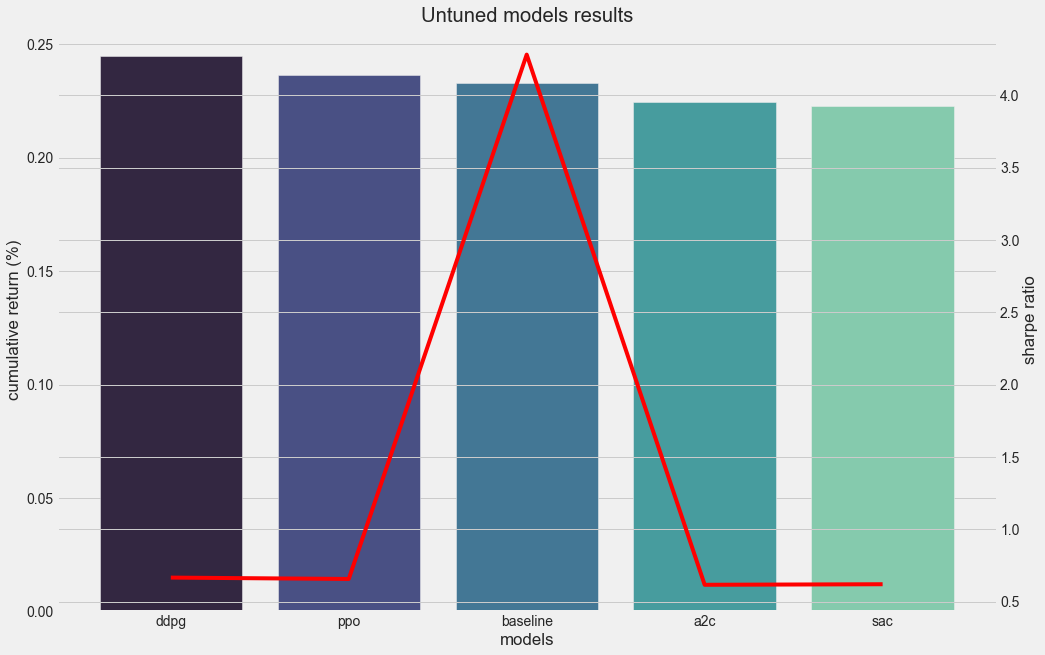

In [123]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.barplot(data = untuned_summary_df, 
                x = 'model', 
                y = 'cumulative_return', 
                palette = sns.color_palette('mako', n_colors=5))

ax2 = plt.twinx()
ax2 = sns.lineplot(data = untuned_summary_df,
                    x = 'model',
                    y = 'sharpe_ratio',
                    color = 'r')

ax.set_title('Untuned models results')
ax.set_ylabel('cumulative return (%)')
ax2.set_ylabel('sharpe ratio')
ax.set_xlabel('models');

## **3.3 Tuned Models**
Now, we'll do some hyperparameter tuning to improve our 4 models. We'll be utilising **optuna** to do this.

The first step is to create our **objective function**. This is the value which optuna will aim to either **minimize** or **maximise**. <br>
In our case, we will be aiming to **maximise** the **sharpe ratio**. <br> <br>
As we using 4 unique algorithms, we'll need to make 4 individual objective functions. <br>
Within each function, we shall pass in the hyperparameter values that we are want to try out. 

In [87]:
import optuna

- We'll use a **sampler** to choose which of our hyperparameters should be tried. <br>
- We'll use a **pruner** to determine when to end a trial early if the results are bad.

In [88]:
sampler = optuna.samplers.TPESampler(seed = 42)
pruner = optuna.pruners.HyperbandPruner()

In [89]:
tuned_models_summary = []

In [95]:
if not os.path.exists('tuned_tensorboard_log'):
    os.makedirs('tuned_tensorboard_log')

In [126]:
def make_model(model_name, params, tensorboard_dir, train_models_dir, time_steps):
  
  agent = DRLAgent(env = env_train)
  params = params

  model = agent.get_model(model_name = model_name,
                          tensorboard_log = tensorboard_dir,
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = model_name,
                                    total_timesteps = time_steps)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  cumulative_return = performance_stats_all[1]

  trained_model.save(f'{train_models_dir}/tuned_{model_name.upper()}.h5')

  summary_dict = {'model': model_name,
                  'daily_returns': df_daily_return,
                  'daily_actions': df_actions,
                  'sharpe_ratio': sharpe_ratio,
                  'cumulative_return': cumulative_return}
  
  return summary_dict

**A2C**

In [127]:
# defining our objective functions
def a2c_objective_function(trial):
  trial_env = env_train
  agent = DRLAgent(env=trial_env)

  params = {
            'n_steps': trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048]),
            'ent_coef': trial.suggest_loguniform("ent_coef", 0.00000001, 0.1),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1)      
            }

  model = agent.get_model(model_name = 'a2c',
                          tensorboard_log = 'tensorboard_log',
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = 'a2c',
                                    total_timesteps = 50000)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  return sharpe_ratio

study_a2c = optuna.create_study(direction = 'maximize')
study_a2c.optimize(a2c_objective_function, n_trials = 20)
a2c_best_params = study_a2c.best_params

# creating our best model
tuned_a2c_summary = make_model('a2c', a2c_best_params, 'tuned_tensorboard_log', 'trained_models', 20000)
tuned_models_summary.append(tuned_a2c_summary)

[I 2022-04-02 00:52:28,939] A new study created in memory with name: no-name-fe39d842-4a9e-4568-bf73-5b636102593b


{'n_steps': 1024, 'ent_coef': 0.0009196406296445249, 'learning_rate': 0.13594461170765396}
Using cuda device
Logging to tensorboard_log\a2c_2
begin_total_asset:1000000
end_total_asset:1932635.5951137785
Sharpe:  0.9549480302817076
begin_total_asset:1000000
end_total_asset:1756396.4322102389
Sharpe:  0.8241255873374502
begin_total_asset:1000000
end_total_asset:2007449.1737379348
Sharpe:  0.9862371205314338
begin_total_asset:1000000
end_total_asset:1977209.5151259059
Sharpe:  0.9663708196541537
begin_total_asset:1000000
end_total_asset:1968014.2168894703
Sharpe:  0.9580219426155285
begin_total_asset:1000000
end_total_asset:1908191.9968308592
Sharpe:  0.9085867496451832
begin_total_asset:1000000
end_total_asset:1960526.5164269684
Sharpe:  0.9470086182179145
begin_total_asset:1000000
end_total_asset:1916454.8529528999
Sharpe:  0.9191710017816279
begin_total_asset:1000000
end_total_asset:1946503.5071070124
Sharpe:  0.9392922268107642
begin_total_asset:1000000
end_total_asset:1960240.8433056

[W 2022-04-02 00:55:56,913] Trial 0 failed because of the following error: NameError("name 'timeseries' is not defined")
Traceback (most recent call last):
  File "C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-127-86f479ff5707>", line 24, in a2c_objective_function
    performance_stats = timeseries.perf_stats
NameError: name 'timeseries' is not defined


begin_total_asset:1000000
end_total_asset:1205693.7634381375
Sharpe:  0.5973704307918178
hit end!


NameError: name 'timeseries' is not defined

**PPO**

In [ ]:
def ppo_objective_function(trial):
  trial_env = env_train
  agent = DRLAgent(env=trial_env)

  params = {
            'n_steps': trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048]),
            'ent_coef': trial.suggest_loguniform("ent_coef", 0.00000001, 0.1),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1),
            'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512])      
            }

  model = agent.get_model(model_name = 'ppo',
                          tensorboard_log = 'tensorboard_log',
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = 'ppo',
                                    total_timesteps = 50000)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  return sharpe_ratio

study_ppo = optuna.create_study(direction = 'maximize')
study_ppo.optimize(ppo_objective_function, n_trials = 20)
ppo_best_params = study_ppo.best_params

# creating our best model
tuned_ppo_summary = make_model('ppo', ppo_best_params, 'tuned_tensorboard_log', 'trained_models', 20000)
tuned_models_summary.append(tuned_ppo_summary)

[I 2022-04-01 05:32:05,269] A new study created in memory with name: no-name-e8a6e20b-59ae-4e03-9e9b-28ccc293a3b7


{'n_steps': 8, 'ent_coef': 0.003791143270391488, 'learning_rate': 8.901208121009093e-05, 'batch_size': 256}
Using cpu device
Logging to tensorboard_log/ppo_1
----------------------------------
| time/              |           |
|    fps             | 206       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 8         |
| train/             |           |
|    reward          | 1013253.4 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 97            |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 16            |
| train/                  |               |
|    approx_kl            | 4.4703484e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -41.1         |
|    explained_variance   | -1.19e-07     |

/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 48008     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.2     |
|    explained_variance   | 0         |
|    learning_rate        | 8.9e-05   |
|    loss                 | 1.26e+13  |
|    n_updates            | 60000     |
|    policy_gradient_loss | -6.59e-06 |
|    reward               | 1159433.1 |
|    std                  | 1         |
|    value_loss           | 2.52e+13  |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 75        |
|    iterations           | 6002      |
|    time_elapsed         | 633       |
|    total_timesteps      | 48016     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0

[I 2022-04-01 05:43:06,314] Trial 0 finished with value: 0.6577678798110721 and parameters: {'n_steps': 8, 'ent_coef': 0.003791143270391488, 'learning_rate': 8.901208121009093e-05, 'batch_size': 256}. Best is trial 0 with value: 0.6577678798110721.


begin_total_asset:1000000
end_total_asset:1236426.878268515
Sharpe:  0.6577678798110721
hit end!
{'n_steps': 8, 'ent_coef': 2.2643287607635404e-05, 'learning_rate': 0.7832011717215202, 'batch_size': 256}
Using cpu device
Logging to tensorboard_log/ppo_2
-----------------------------------
| time/              |            |
|    fps             | 211        |
|    iterations      | 1          |
|    time_elapsed    | 0          |
|    total_timesteps | 8          |
| train/             |            |
|    reward          | 1017093.25 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 16          |
| train/                  |             |
|    approx_kl            | 0.102857016 |
|    clip_fraction        | 0.5         |
|    clip_range           | 0.2         |
| 

/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 48008      |
| train/                  |            |
|    approx_kl            | 0.18648814 |
|    clip_fraction        | 0.512      |
|    clip_range           | 0.2        |
|    entropy_loss         | -37        |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.783      |
|    loss                 | 1.18e+13   |
|    n_updates            | 60000      |
|    policy_gradient_loss | -0.111     |
|    reward               | 1154570.9  |
|    std                  | 0.886      |
|    value_loss           | 2.37e+13   |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 72         |
|    iterations           | 6002       |
|    time_elapsed         | 659        |
|    total_timesteps      | 48016      |
| train/                  |            |
|    approx_kl            | 0.23865989 |
|    c

[I 2022-04-01 05:54:34,640] Trial 1 finished with value: 0.6928603879452736 and parameters: {'n_steps': 8, 'ent_coef': 2.2643287607635404e-05, 'learning_rate': 0.7832011717215202, 'batch_size': 256}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1255448.3357611513
Sharpe:  0.6928603879452737
hit end!
{'n_steps': 128, 'ent_coef': 2.9715284580596563e-08, 'learning_rate': 0.016063601942228316, 'batch_size': 512}
Using cpu device
Logging to tensorboard_log/ppo_3


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 512, but because the `RolloutBuffer` is of size `n_steps * n_envs = 128`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 128
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=128 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 18816        |
| train/                  |              |
|    approx_kl            | 3.678724e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0161       |
|    loss                 | 4.14e+14     |
|    n_updates            | 1460         |
|    policy_gradient_loss | -2.69e-05    |
|    reward               | 1000315.4    |
|    std                  | 1            |
|    value_loss           | 8.29e+14     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 234         |
|    iterations           | 148         |
|    time_elapsed         | 80          |
|    total_timesteps      | 18944       |
| train/                  |             |
|    appro

[I 2022-04-01 05:58:10,330] Trial 2 finished with value: 0.6582639140987621 and parameters: {'n_steps': 128, 'ent_coef': 2.9715284580596563e-08, 'learning_rate': 0.016063601942228316, 'batch_size': 512}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236688.4630523152
Sharpe:  0.6582639140987621
hit end!
{'n_steps': 1024, 'ent_coef': 0.016057952251567233, 'learning_rate': 0.003150197999365856, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ppo_4
----------------------------------
| time/              |           |
|    fps             | 311       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 1024      |
| train/             |           |
|    reward          | 1626748.9 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1876517.4897901043
Sharpe:  0.9087685749628114
-------------------------------------------
| time/                   |               |
|    fps                  | 250           |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 2.4

[I 2022-04-01 06:02:03,527] Trial 3 finished with value: 0.6580766034131709 and parameters: {'n_steps': 1024, 'ent_coef': 0.016057952251567233, 'learning_rate': 0.003150197999365856, 'batch_size': 64}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236591.3480698282
Sharpe:  0.6580766034131709
hit end!
{'n_steps': 512, 'ent_coef': 0.00013251820132451945, 'learning_rate': 0.1373103945730866, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ppo_5
----------------------------------
| time/              |           |
|    fps             | 310       |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 512       |
| train/             |           |
|    reward          | 1344072.0 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00020344218 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2  

[I 2022-04-01 06:05:59,615] Trial 4 finished with value: 0.6577896892998065 and parameters: {'n_steps': 512, 'ent_coef': 0.00013251820132451945, 'learning_rate': 0.1373103945730866, 'batch_size': 64}. Best is trial 1 with value: 0.6928603879452736.


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 42080        |
| train/                  |              |
|    approx_kl            | 4.838966e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0273       |
|    loss                 | 4.24e+13     |
|    n_updates            | 13140        |
|    policy_gradient_loss | -0.00284     |
|    reward               | 1084277.6    |
|    std                  | 1            |
|    value_loss           | 1.2e+14      |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 120           |
|    iterations           | 1316          |
|    time_elapsed         | 350           |
|    total_timesteps      | 42112         |
| train/                  |             

[I 2022-04-01 06:12:58,185] Trial 5 finished with value: 0.6584553952408512 and parameters: {'n_steps': 32, 'ent_coef': 9.944619267742852e-05, 'learning_rate': 0.02726386789067451, 'batch_size': 16}. Best is trial 1 with value: 0.6928603879452736.


Streaming output truncated to the last 5000 lines.
|    policy_gradient_loss | -0.0087      |
|    reward               | 1552383.9    |
|    std                  | 1            |
|    value_loss           | 3.83e+14     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 198          |
|    iterations           | 536          |
|    time_elapsed         | 172          |
|    total_timesteps      | 34304        |
| train/                  |              |
|    approx_kl            | 0.0010602474 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.795        |
|    loss                 | 2.04e+14     |
|    n_updates            | 5350         |
|    policy_gradient_loss | -0.00903     |
|    reward               | 1637568.8    |
|  

[I 2022-04-01 06:17:11,039] Trial 6 finished with value: 0.6424293938401198 and parameters: {'n_steps': 64, 'ent_coef': 7.890346809001433e-06, 'learning_rate': 0.7951489435468322, 'batch_size': 64}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1231617.0114801645
Sharpe:  0.6424293938401199
hit end!
{'n_steps': 1024, 'ent_coef': 3.7154990355317645e-07, 'learning_rate': 0.0006343244134051302, 'batch_size': 512}
Using cpu device
Logging to tensorboard_log/ppo_8
----------------------------------
| time/              |           |
|    fps             | 306       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 1024      |
| train/             |           |
|    reward          | 1630746.4 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1893335.6906864068
Sharpe:  0.9204095805497057
---------------------------------------
| time/                   |           |
|    fps                  | 282       |
|    iterations           | 2         |
|    time_elapsed         | 7         |
|    total_timesteps      | 2048      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fract

[I 2022-04-01 06:20:26,053] Trial 7 finished with value: 0.6582375764100674 and parameters: {'n_steps': 1024, 'ent_coef': 3.7154990355317645e-07, 'learning_rate': 0.0006343244134051302, 'batch_size': 512}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236657.4315503049
Sharpe:  0.6582375764100674
hit end!
{'n_steps': 64, 'ent_coef': 5.0819392720912606e-08, 'learning_rate': 0.0001933508690753184, 'batch_size': 512}
Using cpu device
Logging to tensorboard_log/ppo_9


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 512, but because the `RolloutBuffer` is of size `n_steps * n_envs = 64`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 64
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=64 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    policy_gradient_loss | -4.61e-07 |
|    reward               | 1525925.2 |
|    std                  | 1         |
|    value_loss           | 3.65e+14  |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 198       |
|    iterations           | 536       |
|    time_elapsed         | 172       |
|    total_timesteps      | 34304     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.1     |
|    explained_variance   | 0         |
|    learning_rate        | 0.000193  |
|    loss                 | 1.99e+14  |
|    n_updates            | 5350      |
|    policy_gradient_loss | -1.69e-06 |
|    reward               | 1620416.1 |
|    std                  | 1         |
|    value_loss           | 3

[I 2022-04-01 06:24:39,690] Trial 8 finished with value: 0.6579454320159158 and parameters: {'n_steps': 64, 'ent_coef': 5.0819392720912606e-08, 'learning_rate': 0.0001933508690753184, 'batch_size': 512}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236472.2777018445
Sharpe:  0.6579454320159158
hit end!
{'n_steps': 512, 'ent_coef': 2.060222273889813e-07, 'learning_rate': 0.3000025530214645, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo_10
----------------------------------
| time/              |           |
|    fps             | 312       |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 512       |
| train/             |           |
|    reward          | 1367992.5 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 277           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00026441016 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2 

[I 2022-04-01 06:28:13,555] Trial 9 finished with value: 0.6613883349020011 and parameters: {'n_steps': 512, 'ent_coef': 2.060222273889813e-07, 'learning_rate': 0.3000025530214645, 'batch_size': 128}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1238125.2435170352
Sharpe:  0.6613883349020011
hit end!
{'n_steps': 16, 'ent_coef': 7.336375926753379e-06, 'learning_rate': 1.6136646728984015e-05, 'batch_size': 32}
Using cpu device
Logging to tensorboard_log/ppo_11
----------------------------------
| time/              |           |
|    fps             | 216       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 16        |
| train/             |           |
|    reward          | 1009303.8 |
----------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 32, but because the `RolloutBuffer` is of size `n_steps * n_envs = 16`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=16 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    policy_gradient_loss | -8.83e-07 |
|    reward               | 1753776.8 |
|    std                  | 1         |
|    value_loss           | 1.41e+14  |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 109       |
|    iterations           | 2877      |
|    time_elapsed         | 419       |
|    total_timesteps      | 46032     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.1     |
|    explained_variance   | 0         |
|    learning_rate        | 1.61e-05  |
|    loss                 | 7.51e+13  |
|    n_updates            | 28760     |
|    policy_gradient_loss | -1.31e-06 |
|    reward               | 1789270.9 |
|    std                  | 1         |
|    value_loss           | 1

[I 2022-04-01 06:35:50,054] Trial 10 finished with value: 0.6586724370619202 and parameters: {'n_steps': 16, 'ent_coef': 7.336375926753379e-06, 'learning_rate': 1.6136646728984015e-05, 'batch_size': 32}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236870.501008976
Sharpe:  0.6586724370619202
hit end!
{'n_steps': 512, 'ent_coef': 8.035751945965537e-07, 'learning_rate': 0.9497707172339702, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo_12
----------------------------------
| time/              |           |
|    fps             | 296       |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 512       |
| train/             |           |
|    reward          | 1371185.5 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 273         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.002289989 |
|    clip_fraction        | 0.000781    |
|    clip_range           | 0.2         |
|    entr

[I 2022-04-01 06:39:21,746] Trial 11 finished with value: 0.6605750011834013 and parameters: {'n_steps': 512, 'ent_coef': 8.035751945965537e-07, 'learning_rate': 0.9497707172339702, 'batch_size': 128}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1237192.02184064
Sharpe:  0.6605750011834013
hit end!
{'n_steps': 8, 'ent_coef': 0.00043591268772096454, 'learning_rate': 0.12140611197742773, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo_13
-----------------------------------
| time/              |            |
|    fps             | 133        |
|    iterations      | 1          |
|    time_elapsed    | 0          |
|    total_timesteps | 8          |
| train/             |            |
|    reward          | 1014360.25 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 91         |
|    iterations           | 2          |
|    time_elapsed         | 0          |
|    total_timesteps      | 16         |
| train/                  |            |
|    approx_kl            | 0.03612563 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entrop

/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 48008       |
| train/                  |             |
|    approx_kl            | 0.006089486 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -40.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.121       |
|    loss                 | 1.32e+13    |
|    n_updates            | 60000       |
|    policy_gradient_loss | -0.0318     |
|    reward               | 1187963.2   |
|    std                  | 0.991       |
|    value_loss           | 2.64e+13    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 6002         |
|    time_elapsed         | 712          |
|    total_timesteps      | 48016        |
| train/                  |              |
|    approx_kl    

[I 2022-04-01 06:51:45,097] Trial 12 finished with value: 0.6476913994710021 and parameters: {'n_steps': 8, 'ent_coef': 0.00043591268772096454, 'learning_rate': 0.12140611197742773, 'batch_size': 128}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1228447.7985176037
Sharpe:  0.6476913994710021
hit end!
{'n_steps': 2048, 'ent_coef': 1.07301395176391e-06, 'learning_rate': 0.24125382797892755, 'batch_size': 8}
Using cpu device
Logging to tensorboard_log/ppo_14
begin_total_asset:1000000
end_total_asset:1824478.2063366082
Sharpe:  0.8713742792326299
----------------------------------
| time/              |           |
|    fps             | 289       |
|    iterations      | 1         |
|    time_elapsed    | 7         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1358684.1 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1923449.2896393356
Sharpe:  0.9416186020395227
------------------------------------------
| time/                   |              |
|    fps                  | 133          |
|    iterations           | 2            |
|    time_elapsed         | 30           |
|    total_timesteps      | 4096    

[I 2022-04-01 07:01:44,414] Trial 13 finished with value: 0.6555408766657042 and parameters: {'n_steps': 2048, 'ent_coef': 1.07301395176391e-06, 'learning_rate': 0.24125382797892755, 'batch_size': 8}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1235223.5282950313
Sharpe:  0.6555408766657042
hit end!
{'n_steps': 256, 'ent_coef': 7.6271847922049425e-06, 'learning_rate': 0.01764147837421115, 'batch_size': 256}
Using cpu device
Logging to tensorboard_log/ppo_15
----------------------------------
| time/              |           |
|    fps             | 285       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 256       |
| train/             |           |
|    reward          | 1189962.9 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 275           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 1.7997809e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.

[I 2022-04-01 07:05:07,130] Trial 14 finished with value: 0.658281482195221 and parameters: {'n_steps': 256, 'ent_coef': 7.6271847922049425e-06, 'learning_rate': 0.01764147837421115, 'batch_size': 256}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236646.0051388019
Sharpe:  0.658281482195221
hit end!
{'n_steps': 8, 'ent_coef': 0.0010158205922860188, 'learning_rate': 0.05894410893434583, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo_16
----------------------------------
| time/              |           |
|    fps             | 138       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 8         |
| train/             |           |
|    reward          | 1014580.0 |
----------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 48008        |
| train/                  |              |
|    approx_kl            | 0.0018319637 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.4        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0589       |
|    loss                 | 1.27e+13     |
|    n_updates            | 60000        |
|    policy_gradient_loss | -0.0223      |
|    reward               | 1166506.5    |
|    std                  | 1.01         |
|    value_loss           | 2.55e+13     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 66           |
|    iterations           | 6002         |
|    time_elapsed         | 723          |
|    total_timesteps      | 48016        |
| train/                  |              |
|  

[I 2022-04-01 07:17:41,840] Trial 15 finished with value: 0.6527764890176786 and parameters: {'n_steps': 8, 'ent_coef': 0.0010158205922860188, 'learning_rate': 0.05894410893434583, 'batch_size': 128}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1238350.2448714369
Sharpe:  0.6527764890176786
hit end!
{'n_steps': 512, 'ent_coef': 1.208866092924395e-07, 'learning_rate': 0.005479473943460083, 'batch_size': 256}
Using cpu device
Logging to tensorboard_log/ppo_17
----------------------------------
| time/              |           |
|    fps             | 303       |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 512       |
| train/             |           |
|    reward          | 1326346.6 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 288           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.4680048e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.

[I 2022-04-01 07:21:01,637] Trial 16 finished with value: 0.657575808174538 and parameters: {'n_steps': 512, 'ent_coef': 1.208866092924395e-07, 'learning_rate': 0.005479473943460083, 'batch_size': 256}. Best is trial 1 with value: 0.6928603879452736.


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 18816       |
| train/                  |             |
|    approx_kl            | 0.005219206 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.277       |
|    loss                 | 3.29e+14    |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0175     |
|    reward               | 1001107.5   |
|    std                  | 1           |
|    value_loss           | 7.85e+14    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 148          |
|    time_elapsed         | 224          |
|    total_timesteps      | 18944        |
| train/                  |              |
|    approx_kl    

[I 2022-04-01 07:31:00,045] Trial 17 finished with value: 0.6557257637177287 and parameters: {'n_steps': 128, 'ent_coef': 2.1059943178422814e-05, 'learning_rate': 0.2770926760247823, 'batch_size': 8}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1232236.9863758588
Sharpe:  0.6557257637177286
hit end!
{'n_steps': 256, 'ent_coef': 0.08869633063449463, 'learning_rate': 0.9529712110477975, 'batch_size': 32}
Using cpu device
Logging to tensorboard_log/ppo_19
----------------------------------
| time/              |           |
|    fps             | 296       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 256       |
| train/             |           |
|    reward          | 1173737.5 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 213         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 512         |
| train/                  |             |
|    approx_kl            | 0.012227323 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entrop

[I 2022-04-01 07:35:51,367] Trial 18 finished with value: 0.6342405687810947 and parameters: {'n_steps': 256, 'ent_coef': 0.08869633063449463, 'learning_rate': 0.9529712110477975, 'batch_size': 32}. Best is trial 1 with value: 0.6928603879452736.


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 42080        |
| train/                  |              |
|    approx_kl            | 3.017485e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00332      |
|    loss                 | 6.26e+13     |
|    n_updates            | 13140        |
|    policy_gradient_loss | -0.000192    |
|    reward               | 1090785.2    |
|    std                  | 1            |
|    value_loss           | 1.23e+14     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterations           | 1316         |
|    time_elapsed         | 363          |
|    total_timesteps      | 42112        |
| train/                  |              |
|  

[I 2022-04-01 07:43:05,713] Trial 19 finished with value: 0.65791248130907 and parameters: {'n_steps': 32, 'ent_coef': 1.2449616834276893e-08, 'learning_rate': 0.003319986809403031, 'batch_size': 16}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236411.9657066222
Sharpe:  0.65791248130907
hit end!
{'n_steps': 8, 'ent_coef': 2.2643287607635404e-05, 'learning_rate': 0.7832011717215202, 'batch_size': 256}
Using cpu device
Logging to tuned_tensorboard_log/ppo_1
-----------------------------------
| time/              |            |
|    fps             | 122        |
|    iterations      | 1          |
|    time_elapsed    | 0          |
|    total_timesteps | 8          |
| train/             |            |
|    reward          | 1018535.56 |
-----------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    explained_variance   | 0           |
|    learning_rate        | 0.783       |
|    loss                 | 1.47e+13    |
|    n_updates            | 22500       |
|    policy_gradient_loss | -0.101      |
|    reward               | 1302356.6   |
|    std                  | 0.967       |
|    value_loss           | 2.95e+13    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 61         |
|    iterations           | 2252       |
|    time_elapsed         | 291        |
|    total_timesteps      | 18016      |
| train/                  |            |
|    approx_kl            | 0.12084084 |
|    clip_fraction        | 0.4        |
|    clip_range           | 0.2        |
|    entropy_loss         | -40        |
|    explained_variance   | 0          |
|    learning_rate        | 0.783      |
|    loss                 | 1.55e+13  

**DDPG**

In [ ]:
def ddpg_objective_function(trial):
  trial_env = env_train
  agent = DRLAgent(env=trial_env)

  params = {
            'buffer_size':  trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)]),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1),
            'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512])      
            }

  model = agent.get_model(model_name = 'ddpg',
                          tensorboard_log = 'tensorboard_log',
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = 'ddpg',
                                    total_timesteps = 50000)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  return sharpe_ratio

study_ddpg = optuna.create_study(direction = 'maximize')
study_ddpg.optimize(ddpg_objective_function, n_trials = 20)
ddpg_best_params = study_ddpg.best_params

# creating our best model
tuned_ddpg_summary = make_model('ddpg', ddpg_best_params, 'tuned_tensorboard_log', 'trained_models', 20000)
tuned_models_summary.append(tuned_ddpg_summary)

[I 2022-04-01 07:48:30,119] A new study created in memory with name: no-name-53fcee32-a58e-4fec-8f7d-b7786051866c


{'buffer_size': 10000, 'learning_rate': 2.0787222446006676e-05, 'batch_size': 512}
Using cpu device
Logging to tensorboard_log/ddpg_1
begin_total_asset:1000000
end_total_asset:2004657.2360774435
Sharpe:  1.0013832945033923
begin_total_asset:1000000
end_total_asset:2004334.1395860736
Sharpe:  1.001236870555199
begin_total_asset:1000000
end_total_asset:2004334.1395860736
Sharpe:  1.001236870555199
begin_total_asset:1000000
end_total_asset:2004334.1395860736
Sharpe:  1.001236870555199
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 8         |
|    time_elapsed    | 656       |
|    total_timesteps | 5788      |
| train/             |           |
|    actor_loss      | -3.33e+06 |
|    critic_loss     | 2.18e+11  |
|    learning_rate   | 2.08e-05  |
|    n_updates       | 4341      |
|    reward          | 2004334.1 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2004334.13958607

**SAC**

In [ ]:
def sac_objective_function(trial):
  trial_env = env_train
  agent = DRLAgent(env=trial_env)

  params = {
            'buffer_size':  trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)]),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1),
            'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512]),
            'learning_starts': trial.suggest_categorical("learning_starts", [0, 1000, 10000, 20000])  
            }

  model = agent.get_model(model_name = 'sac',
                          tensorboard_log = 'tensorboard_log',
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = 'sac',
                                    total_timesteps = 50000)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  return sharpe_ratio

study_sac = optuna.create_study(direction = 'maximize')
study_sac.optimize(sac_objective_function, n_trials = 20)
sac_best_params = study_sac.best_params

# creating our best model
tuned_sac_summary = make_model('sac', sac_best_params, 'tuned_tensorboard_log', 'trained_models', 20000)
tuned_models_summary.append(tuned_sac_summary)

In [ ]:
tuned_models_summary.append({
                             'model': 'baseline',
                             'cumulative_return': baseline_validation_cum_sum,
                             'sharpe_ratio': baseline_validation_sharpe_ratio
})

with open('data/tuned_summary.pickle', 'wb') as handle:
  pickle.dump(tuned_models_summary, handle, protocol = pickle.HIGHEST_PROTOCOL)